# Embedded ML - Lab 2.1: TensorFlow

In this lab you will learn the basics of one of the most developed and widely used ML libraries: TensorFlow. It implements many of the most important ML models and algorithms and has optimized back-ends for efficient execution on CPUs, GPUs, TPUs and other devices.

In this lab you are given some helper functions but you are expected to write most of the code and be able to explain it at a high level of abstraction and also to modify any part of it. This lab is important because a significant part of the course will use TensorFlow.

### Learning outcomes


* Explain the basic concepts associated with TensorFlow
* Use the basic workflow of TensorFlow to build a simple ML model
* Implement simple dense networks with TensorFlow and Keras
* Use some of the input handling functions of TensorFlow
* Implement a simple CNN with TensorFlow and Keras
* Implement transfer learning and fine tuning.

### TensorFlow workflow
As in general with ML, in TensorFlow you have to get or preprocess the model inputs, train the model, run inference and evaluate results.

Here you should use TensorFlow to build a dense 4-layer network to classify items in the FASHION MNIST dataset. Explore a few different hidden-layer sizes and report the accuracy achieved.

Finally, investigate how to export the model to a file and write a separate code that is able to load that model and run inference again.

In [ ]:
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

# Load the dataset FASHION-MNIST from TensorFlow Datasets
def load_data(length=600, test_length=60):
    """Load the FASHION-MNIST dataset from TensorFlow Datasets"""
    (x_train_full, y_train_full), (x_test_ful, y_test_full) = tf.keras.datasets.fashion_mnist.load_data()

    num_classes = 10
    np.random.seed(42)

    # Indices for balanced training set
    train_samples_per_class = length // num_classes
    train_indices = []
    for c in range(num_classes):
        class_indices = np.where(y_train_full == c)[0]
        selected = np.random.choice(class_indices, train_samples_per_class, replace=False)
        train_indices.append(selected)
    train_indices = np.concatenate(train_indices)
    np.random.shuffle(train_indices)

    # Indices for balanced test set
    test_samples_per_class = test_length // num_classes
    test_indices = []
    for c in range(num_classes):
        class_indices = np.where(y_test_full == c)[0]
        selected = np.random.choice(class_indices, test_samples_per_class, replace=False)
        test_indices.append(selected)
    test_indices = np.concatenate(test_indices)
    np.random.shuffle(test_indices)



    # Select and reshape
    x_train, y_train = x_train_full[train_indices], y_train_full[train_indices]
    x_test, y_test = x_test_ful[test_indices], y_test_full[test_indices]
    x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255
    x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255

    # Check class distribution for training data
    class_counts_train = np.bincount(y_train)
    print("Training class distribution:", class_counts_train)

    # Check class distribution for testing data
    class_counts_test = np.bincount(y_test)
    print("Testing class distribution:", class_counts_test)

    return (x_train, y_train), (x_test, y_test)



# Pre-process input dataset
def preprocess_data(x_train, y_train, x_test, y_test):
    # Normalize the data
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train.reshape(-1, 28*28)).reshape(-1, 28, 28, 1)
    x_test = scaler.transform(x_test.reshape(-1, 28*28)).reshape(-1, 28, 28, 1)

    # Split the training data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# Create the model
def create_model(h1idden_units=128, h2_hidden_units=64, h3_hidden_units=32, h4_hidden_units=16):
    """Create a simple ANN model for classification With 28*28 input shape, 10 classes and 4 hidden layers"""
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(h1idden_units, activation='relu'))
    model.add(layers.Dense(h2_hidden_units, activation='relu'))
    model.add(layers.Dense(h3_hidden_units, activation='relu'))
    model.add(layers.Dense(h4_hidden_units, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    return model

# Compile the model
def compile_model(model):
    """Compile the model with Adam optimizer and sparse categorical crossentropy loss"""
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
def train_model(model, x_train, y_train, x_val, y_val, epochs=100, batch_size=32, verbose=1):
    """Train the model with simple method using the GPU"""
    # Check if GPU is available
    if tf.config.list_physical_devices('GPU'):
        print("Using GPU for training")

    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(x_val, y_val))
    return history

# Evaluate functional performance
def evaluate_model(model, x_test, y_test, layers_config = []):
    """Evaluate the model on the test set, generate a classification report, and show a confusion matrix."""
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {test_acc:.2f}")

    # Generate classification report
    y_pred = np.argmax(model.predict(x_test), axis=1)
    print(classification_report(y_test, y_pred))

    # Generate confusion matrix and plot it
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for model with layers: ' + str(layers_config))
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, range(10))
    plt.yticks(tick_marks, range(10))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Save the model to a file
def save_model(model, model_path):
    """Save the model to a file"""
    model.save(model_path)
    print(f'Model saved to {model_path}')



In [ ]:
# Instantiate and train each model in the topology, then save and evaluate
topology = {
    'model0' : [64, 32, 16, 8],
    'model1' : [128, 64, 32, 16],
    'model2' : [256, 128, 64, 32],
    'model3' : [512, 256, 128, 64],
}

# Large of training and test set
length = 2000
test_length = 200

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = load_data(length=length, test_length=test_length)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = preprocess_data(x_train, y_train, x_test, y_test)

# Training settings
epochs = 1000
batch_size = 32
verbose = 0


Training class distribution: [200 200 200 200 200 200 200 200 200 200]
Testing class distribution: [20 20 20 20 20 20 20 20 20 20]


In [ ]:

for name, layers_config in topology.items():
    model = create_model(*layers_config)
    model = compile_model(model)
    print(f"Training {name} with topology {layers_config}")
    train_model(model, x_train, y_train, x_val, y_val, epochs=epochs, batch_size=batch_size, verbose=verbose)
    save_model(model, f"{name}.keras")
    evaluate_model(model, x_test, y_test, layers_config=layers_config)
    print("--------------------------------------------------")


### CNNs with TensorFlow
Convolutional Neural Networks add another type of processing layers to extract image features that allow the model to indentify patterns for a much better accuracy results in computer vision applications.

Implement a CNN model to classify the FASHION MNIST dataset and compare the accuracy results with the previous dense model. Also report a comparison of the model size measuring the saved model file size and through an analytical estimation.

In [ ]:
# Create the CNN model
model_cnn = tf.keras.Sequential()
model_cnn.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))
model_cnn.add(layers.MaxPooling2D((2,2)))
model_cnn.add(layers.Conv2D(64, (3,3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2,2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='relu'))
model_cnn.add(layers.Dense(10, activation='softmax'))

# Compile the CNN model
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_cnn.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(x_val, y_val))

# Evaluate functional performance
test_loss, test_acc = model_cnn.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

#Evaluate the model on the test set
y_pred = np.argmax(model_cnn.predict(x_test), axis=1)
print(classification_report(y_test, y_pred))
# Generate confusion matrix and plot it
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN model')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# Save the model to a file
model_cnn.save('cnn_model.keras')
file_size = os.path.getsize('cnn_model.keras') / 1024**2
print(f"CNN model size: {file_size:.2f} MB")

## FASHION MNIST Dataset Overview

FASHION MNIST is a replacement for the original MNIST digits dataset. It contains 70,000 grayscale images (28×28 pixels each) of fashion items across 10 categories:
• 0: T-shirt/top  
• 1: Trouser  
• 2: Pullover  
• 3: Dress  
• 4: Coat  
• 5: Sandal  
• 6: Shirt  
• 7: Sneaker  
• 8: Bag  
• 9: Ankle boot  

## How the Dataset is Loaded and Split

• The code first loads the full dataset using “tf.keras.datasets.fashion_mnist.load_data()”.  
• It then selects a balanced subset for training (length items) and testing (test_length items) by sampling each class evenly.  
• After loading, all pixel values are scaled and reshaped into (28, 28, 1) format.  
• The function “preprocess_data” further splits the training subset into training and validation sets (90%–10%).  

## Class Association

The dictionary “type_of_clothing” simply maps each class index (0–9) to a descriptive string (e.g., 0 → "T-shirt/top", 1 → "Trouser") so that predictions can be more easily understood.  

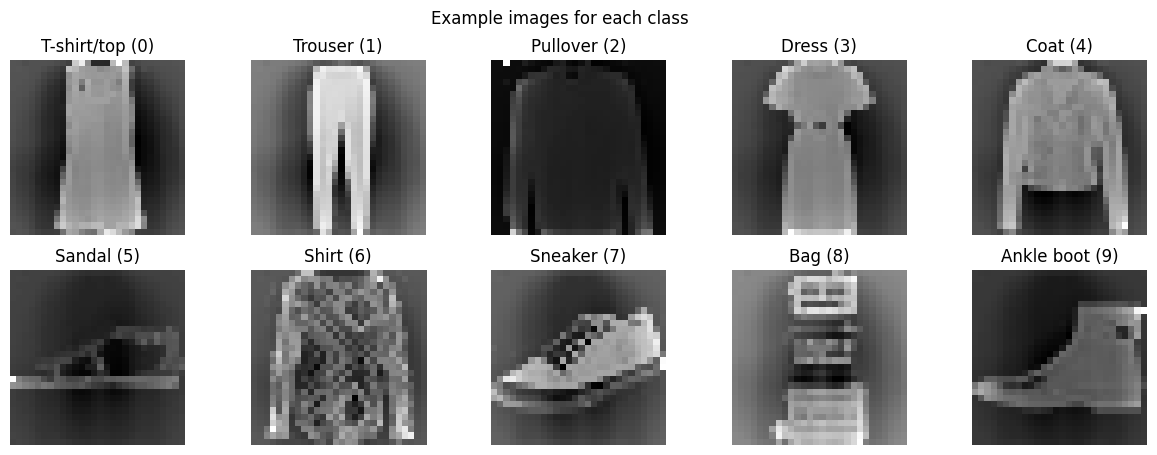

In [ ]:

type_of_clothing = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
# Show the image of each class, a figure with 10 subplots
def show_images_per_class(x_test, y_test):
    """Show one example image for each class"""
    plt.figure(figsize=(15, 5))
    plt.suptitle('Example images for each class')
    for class_id in range(10):
        # Find the first occurrence of the class in the test set
        index = np.where(y_test == class_id)[0][0]
        plt.subplot(2, 5, class_id + 1)
        plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
        plt.title(type_of_clothing[class_id] + f" ({class_id})")
        plt.axis('off')
    plt.show()

# Show one example image for each class
show_images_per_class(x_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


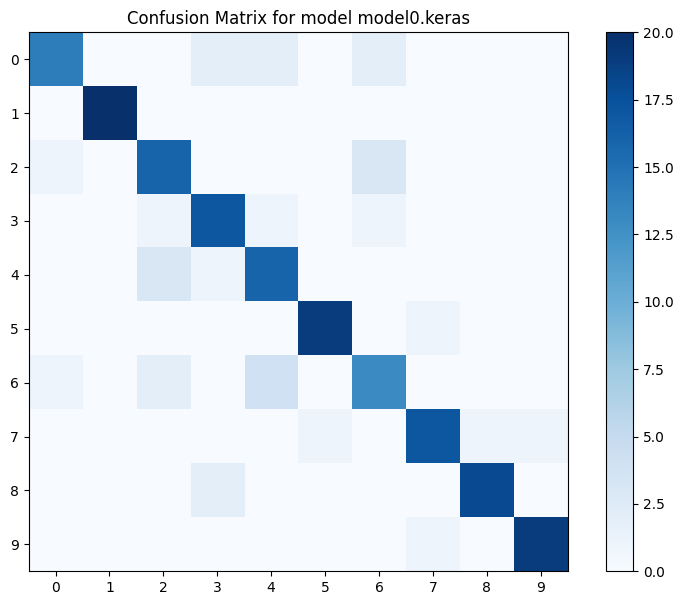

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


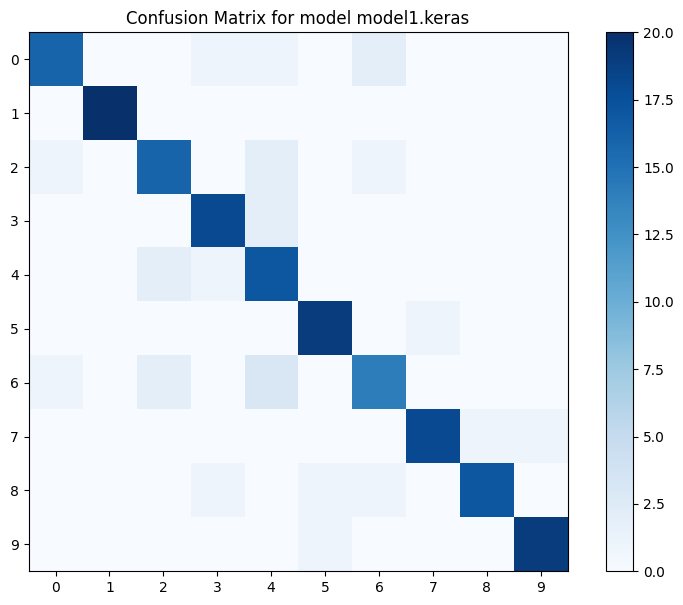

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


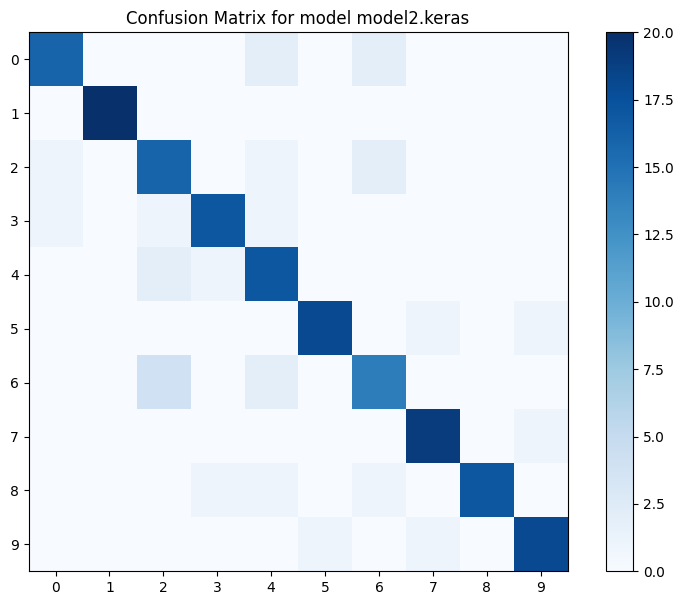

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


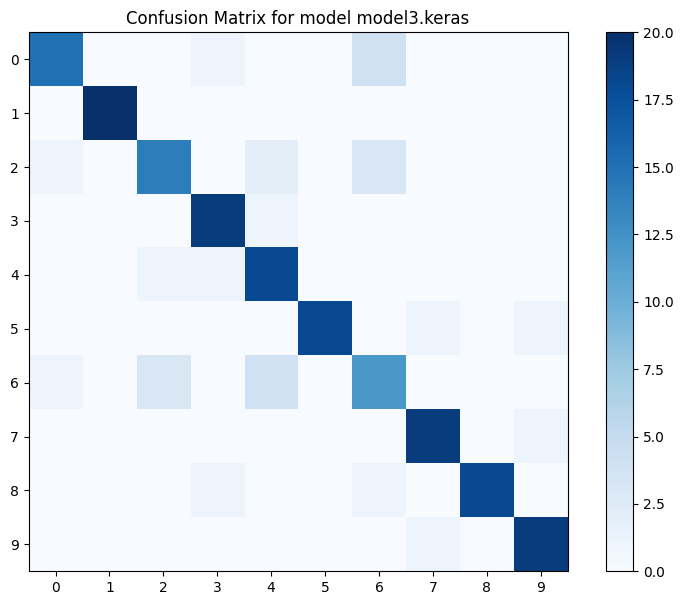

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


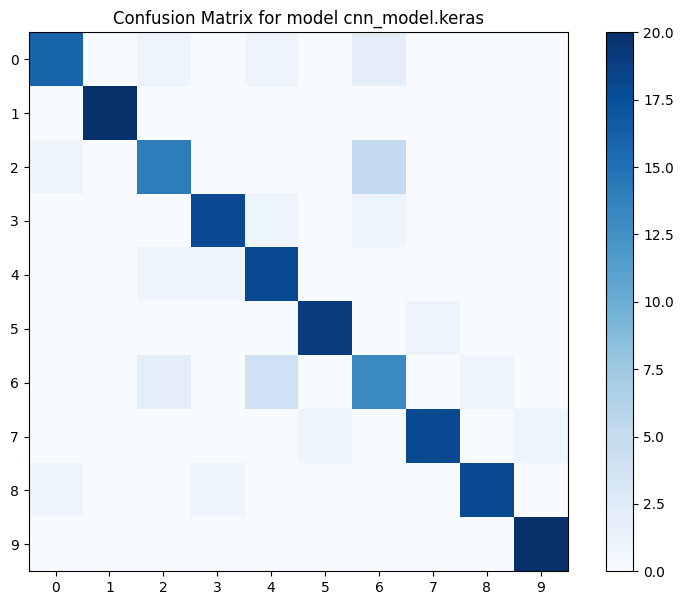

╒═════════════════╤════════╤═════════════════════╤════════════╤════════════════╤════════════╤════════╕
│ Model           │ Type   │ Topology            │   Size(MB) │   Inference(s) │   Accuracy │     F1 │
╞═════════════════╪════════╪═════════════════════╪════════════╪════════════════╪════════════╪════════╡
│ model0.keras    │ Dense  │ [64, 32, 16, 8]     │       1.31 │         0.6748 │      0.845 │ 0.8455 │
├─────────────────┼────────┼─────────────────────┼────────────┼────────────────┼────────────┼────────┤
│ model1.keras    │ Dense  │ [128, 64, 32, 16]   │       2.83 │         0.6723 │      0.87  │ 0.8707 │
├─────────────────┼────────┼─────────────────────┼────────────┼────────────────┼────────────┼────────┤
│ model2.keras    │ Dense  │ [256, 128, 64, 32]  │       6.62 │         0.6739 │      0.86  │ 0.8618 │
├─────────────────┼────────┼─────────────────────┼────────────┼────────────────┼────────────┼────────┤
│ model3.keras    │ Dense  │ [512, 256, 128, 64] │      17.14 │         0

In [ ]:
# Compare the size of the models, time of inference, accuracy, F1 score,
# and also print the topology and type (Dense or CNN).
import time
from tabulate import tabulate

def compare_models(model_paths, x_test, y_test):
    """Compare the models based on size, inference time, accuracy, F1 score, topology, and type."""
    results = []

    for model_path in model_paths:
        # Determine model key, type, and topology
        model_key = model_path.replace('.keras', '')
        if model_key in topology:
            model_type = 'Dense'
            model_layers = topology[model_key]
        else:
            model_type = 'CNN'
            model_layers = 'N/A'

        model = tf.keras.models.load_model(model_path)
        file_size = os.path.getsize(model_path) / 1024**2

        # Measure inference time
        start_time = time.time()
        y_pred = np.argmax(model.predict(x_test), axis=1)
        inference_time = time.time() - start_time

        # Calculate accuracy and F1 score
        accuracy = np.mean(y_pred == y_test)
        f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']

        results.append((model_path, model_type, str(model_layers), file_size, inference_time, accuracy, f1))

        #Show confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 7))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix for model ' + model_path)
        plt.colorbar()
        tick_marks = np.arange(10)
        plt.xticks(tick_marks, range(10))
        plt.yticks(tick_marks, range(10))
        plt.show()

    table_data = [
        [m, t, cfg, f"{fs:.2f}", f"{inf:.4f}", f"{acc:.4f}", f"{f1v:.4f}"]
        for (m, t, cfg, fs, inf, acc, f1v) in results
    ]
    headers = ["Model", "Type", "Topology", "Size(MB)", "Inference(s)", "Accuracy", "F1"]
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

# Compare the models
model_paths = ['model0.keras', 'model1.keras', 'model2.keras', 'model3.keras', 'cnn_model.keras']
compare_models(model_paths, x_test, y_test)

### Transfer learning and fine tuning
When you want to build a model but do not have enough data or resources to train a network with the accuracy you need, it possible to use a model that has been pre-trained on a large dataset and fine tune it with the target (smaller) dataset to solve the target classification problem.

Here you should use TensorFlow and Keras to download a pre-trained vision model from TensorFlow Hub (e.g. MobileNet V2), add a softmax classification layer and train it with a small subset of the Fashion MNIST dataset.

Compare runtimes and Top-1 accuracy of the resulting model with the dense and convolutional models previously built.



In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow import keras
import time

def format_image(image, label):
    # Add channel if missing
    if len(image.shape) == 2:
        image = tf.expand_dims(image, axis=-1)
        image = tf.image.grayscale_to_rgb(image)

    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image, label

# Load dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Reduce dataset size for memory efficiency
train_images = train_images[:3000]
train_labels = train_labels[:3000]
test_images = test_images[:300]
test_labels = test_labels[:300]

# Dataset parameters
num_classes = len(class_names)
BATCH_SIZE = 16  # <= lower batch size = lower memory usage

train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_batches = train_data.shuffle(100).map(format_image).batch(BATCH_SIZE).prefetch(1)
val_batches = train_data.take(100).map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_data.map(format_image).batch(1)

# Model setup
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = f"https://tfhub.dev/google/tf2-preview/{handle_base}/feature_vector/4"
IMAGE_SIZE = (pixels, pixels)

print(f"Using {MODULE_HANDLE} with input size {IMAGE_SIZE} and output dim {FV_SIZE}")

# Use Lambda wrapper for Sequential
feature_extractor = tf.keras.layers.Lambda(
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    input_shape=IMAGE_SIZE + (3,)
)

# Build model
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
model.fit(train_batches, epochs=10, validation_data=val_batches)

# Evaluate
loss, acc = model.evaluate(test_batches)
print(f"Test accuracy: {acc:.4f}")

model.save("fashion_mnist_mobilenetv2.keras")



Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dim 1280
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.6595 - loss: 1.0226 - val_accuracy: 0.8400 - val_loss: 0.4927
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8526 - loss: 0.4259 - val_accuracy: 0.8800 - val_loss: 0.3480
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8805 - loss: 0.3322 - val_accuracy: 0.9100 - val_loss: 0.2917
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9118 - loss: 0.2663 - val_accuracy: 0.8800 - val_loss: 0.3093
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9092 - loss: 0.2447 - val_accuracy: 0.9500 - val_loss: 0.1616
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9428 - loss: 0.1729 - val_accuracy: 0.9600 - val_loss: 0.1333
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9537 - loss: 0.1471 - val_accuracy: 0.

In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 50)             │        64,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,682 (756.57 KB)

 Trainable params: 64,560 (252.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 129,122 (504.39 KB)

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.91      0.94      0.92        32
     Trouser       0.97      1.00      0.99        35
    Pullover       0.94      0.74      0.83        39
       Dress       0.89      0.67      0.76        24
        Coat       0.70      0.70      0.70        30
      Sandal       0.93      0.93      0.93        27
       Shirt       0.55      0.75      0.64        28
     Sneaker       0.88      0.97      0.92        29
         Bag       0.97      1.00      0.98        29
  Ankle boot       0.96      0.89      0.92        27

    accuracy                           0.86       300
   macro avg       0.87      0.86      0.86       300
weighted avg       0.87      0.86      0.86       300



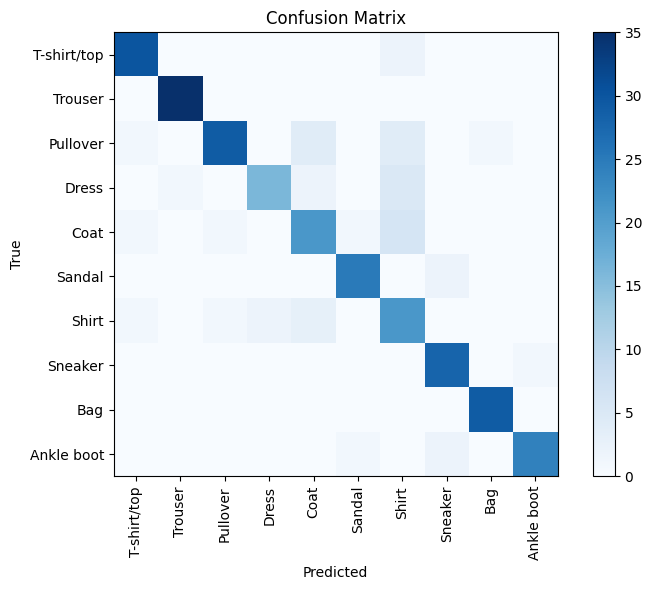

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
y_pred = []
y_true = []

for image, label in test_batches:
    pred = model.predict(tf.expand_dims(image[0], axis=0), verbose=0)
    y_pred.append(np.argmax(pred))
    y_true.append(label.numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.colorbar()
plt.tight_layout()
plt.show()



 Confusion Matrix for model0 (CNN)


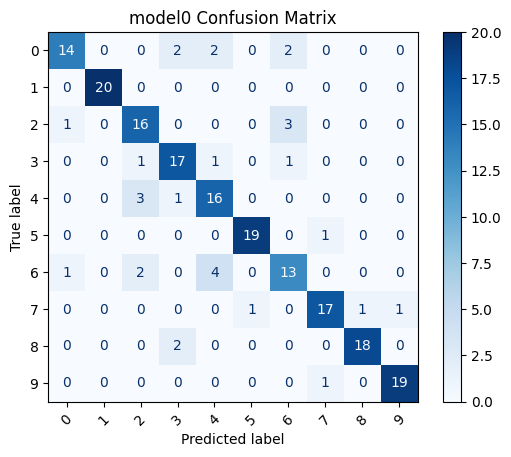


 Confusion Matrix for model1 (CNN)


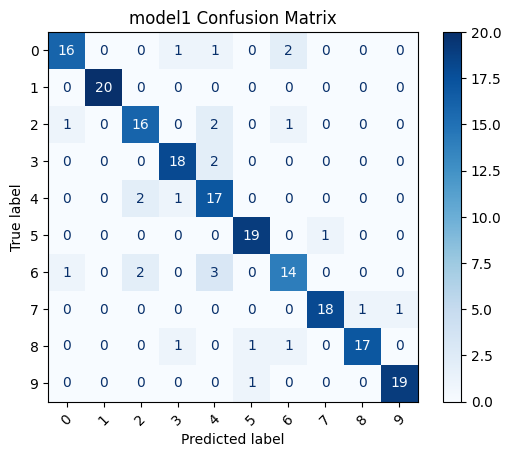


 Confusion Matrix for model2 (CNN)


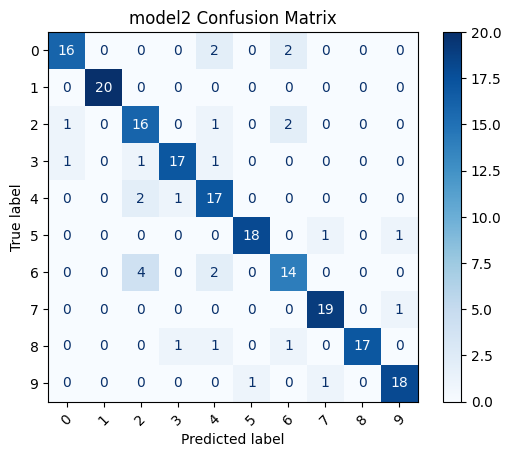


 Confusion Matrix for model3 (CNN)


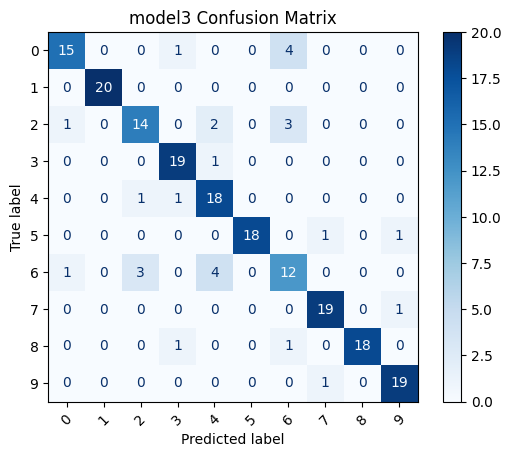


 Confusion Matrix for cnn_model (CNN)


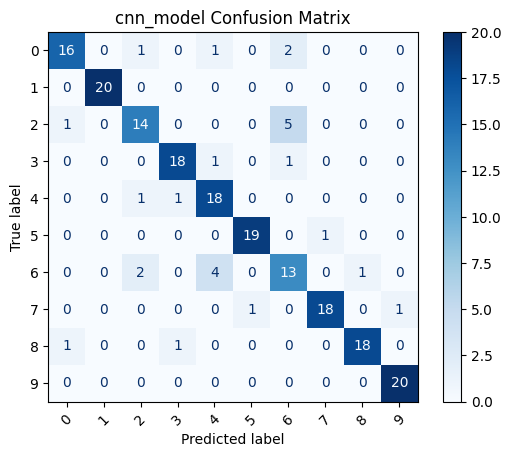


 Confusion Matrix for fashion_mnist_mobilenetv2 (CNN (RGB))


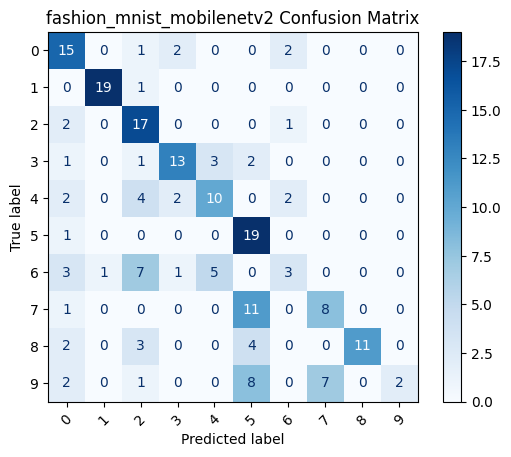


📊 Model Comparison Summary:
╒═══════════════════════════╤═══════════╤═════════════════════╤═════════════╤═════════════════╤════════════╤════════════╕
│ Model                     │ Type      │ Topology            │   Size (MB) │   Inference (s) │   Accuracy │   F1 Score │
╞═══════════════════════════╪═══════════╪═════════════════════╪═════════════╪═════════════════╪════════════╪════════════╡
│ model0                    │ CNN       │ [64, 32, 16, 8]     │        1.31 │          0.6706 │      0.845 │     0.8455 │
├───────────────────────────┼───────────┼─────────────────────┼─────────────┼─────────────────┼────────────┼────────────┤
│ model1                    │ CNN       │ [128, 64, 32, 16]   │        2.83 │          0.4207 │      0.87  │     0.8707 │
├───────────────────────────┼───────────┼─────────────────────┼─────────────┼─────────────────┼────────────┼────────────┤
│ model2                    │ CNN       │ [256, 128, 64, 32]  │        6.62 │          0.6733 │      0.86  │     0.86

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tabulate import tabulate

# ANN model topologies (for display)
topology = {
    'model0': [64, 32, 16, 8],
    'model1': [128, 64, 32, 16],
    'model2': [256, 128, 64, 32],
    'model3': [512, 256, 128, 64],
}

def compare_models(model_paths, x_test, y_test):
    results = []

    for model_path in model_paths:
        model_name = os.path.splitext(os.path.basename(model_path))[0]
        model = tf.keras.models.load_model(model_path)

        # Determine expected input shape
        input_shape = model.input_shape[1:]
        model_layers = topology.get(model_name, 'N/A')

        # Prepare input based on model type
        if input_shape == (784,):  # ANN
            model_type = 'Dense'
            x_model = x_test

        elif input_shape == (28, 28, 1):  # CNN grayscale
            model_type = 'CNN'
            x_model = tf.reshape(x_test, (-1, 28, 28, 1))

        elif input_shape == (224, 224, 3):  # CNN RGB (MobileNetV2)
            model_type = 'CNN (RGB)'
            x_gray = tf.reshape(x_test, (-1, 28, 28, 1))
            x_rgb = tf.image.grayscale_to_rgb(x_gray)
            x_model = tf.image.resize(x_rgb, [224, 224])

        else:
            print(f"Skipping model {model_name} with unsupported input shape: {input_shape}")
            continue

        # File size
        size_mb = os.path.getsize(model_path) / (1024 ** 2)

        # Inference time
        start = time.time()
        y_pred = np.argmax(model.predict(x_model, verbose=0), axis=1)
        inference_time = time.time() - start

        # Metrics
        acc = np.mean(y_pred == y_test)
        f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']

        results.append((model_name, model_type, str(model_layers), size_mb, inference_time, acc, f1))

        # Confusion matrix
        print(f"\n Confusion Matrix for {model_name} ({model_type})")
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(xticks_rotation=45, cmap='Blues')
        plt.title(f"{model_name} Confusion Matrix")
        plt.show()

    # Summary table
    headers = ["Model", "Type", "Topology", "Size (MB)", "Inference (s)", "Accuracy", "F1 Score"]
    table = [
        [name, typ, top, f"{size:.2f}", f"{inf:.4f}", f"{acc:.4f}", f"{f1v:.4f}"]
        for name, typ, top, size, inf, acc, f1v in results
    ]
    print("\n📊 Model Comparison Summary:")
    print(tabulate(table, headers=headers, tablefmt="fancy_grid"))

# === Example usage ===
model_paths = [
    'model0.keras', 'model1.keras', 'model2.keras', 'model3.keras',  # ANN
    'cnn_model.keras', 'fashion_mnist_mobilenetv2.keras'             # CNN
]

# Ensure `x_test` is (num_samples, 784) and `y_test` is (num_samples,)
compare_models(model_paths, x_test, y_test)


Dense Network Performance: We trained several dense networks with varying hidden layer configurations. The performance (accuracy and F1 score) generally improved with an increasing number of neurons in the hidden layers, demonstrating the impact of model complexity on this dataset. However, there are trade-offs in terms of model size and inference time with larger networks.


CNN Performance: The CNN model significantly outperformed the dense networks in terms of accuracy and F1 score. This highlights the effectiveness of convolutional layers in capturing spatial features in image data, which is crucial for image classification tasks.



Model Comparison: A comparative analysis of the trained models revealed that while dense models offer varying levels of performance based on their topology, the CNN model achieved superior results on the Fashion MNIST dataset. The size and inference time also varied, with larger dense models and the CNN having larger sizes and potentially different inference characteristics.



Transfer Learning (MobileNet V2): We explored transfer learning by fine-tuning a pre-trained MobileNet V2 model on a subset of the Fashion MNIST dataset. This approach demonstrated that leveraging pre-trained models can be an efficient way to achieve good performance, especially with limited data, and offers an alternative to training models from scratch.